# <center> A Quantum distance-based classifier </center>#
## <center> Robert Wezeman, TNO </center> ##

<a name="contents"></a>
# Table of Contents
* [Introduction](#introduction)
* [Problem](#problem)
* [Theory](#theory)
* [Algorithm](#algorithm)
* [Implementation](#implementation)
* [Conclusion and further work](#conclusion)

$$ \newcommand{\ket}[1]{\left|{#1}\right\rangle} $$

In [1]:
## Import external python file
import nbimporter
from data_plotter import DataPlotter  # for easier plotting 
DataPlotter = DataPlotter()

# Import math functions 
from math import acos, pi
from numpy import sign

# Import plotting tools
import matplotlib.pyplot as plt

<a name="introduction"></a>
# Introduction #


In the first part of this notebook series on a distance-based classifier, we looked at how to implement a distance-based classifier on the quantum inspire using QASM code. We looked at the simplest possible case, that is: using two data points, each with two features, to assign a label (classify) to a random test point, see image. In this notebook we will extend the previous classifier, by increasing the number of data points to four. In this notebook we demonstrate how to use the projectQ framework to do this. 

<img src="images/4pointsclassifier.png">



[Back to Table of Contents](#contents)

<a name="problem"></a>
# Problem #
Again we have the following binary classification problem: Given the data set 
$$\mathcal{D} = \Big\{ ({\bf x}_1, y_1), \ldots ({\bf x}_M , y_M)  \Big\},$$
consisting of $M$ data points $x_i\in\mathbb{R}^n$ and corresponding labels $y_i\in \{-1, 1\}$, give a prediction for the label $\tilde{y}$ corresponding to an unlabeled data point $\bf\tilde{x}$. The classifier we shall implement with our quantum circuit is a distance-based classifier and is given by
\begin{equation}\newcommand{\sgn}{{\rm sgn}}\newcommand{\abs}[1]{\left\lvert#1\right\rvert}\label{eq:classifier} \tilde{y} = \sgn\left(\sum_{m=0}^{M-1} y_m \left[1-\frac{1}{4M}\abs{{\bf\tilde{x}}-{\bf x}_m}^2\right]\right). \hspace{3cm} (1)\end{equation}

This is a typical $M$-nearest-neighbor model where each data point is given a weight related to the distance measure. To implement this classifier on a quantum computer we use amplitude encoding. For the details see the previous notebook.

[Back to Contents](#contents)

<a name="theory"></a>
# Theory #

<a name="state"></a>
The algorithm requires a $n$-qubit quantum system to be in the following state initially 
\begin{equation}\label{eq:prepstate}
    \ket{\mathcal{D}} = \frac{1}{\sqrt{2M}} \sum_{m=0}^{M-1} \ket{m}\Big(\ket{0}\ket{\psi_{\bf\tilde{{x}}}} + \ket{1}\ket{\psi_{\bf{x}_m}}\Big)\ket{y_m}.\hspace{3cm} (2)
\end{equation}

Here $\ket{m}$ is the $m^{th}$ state of the computational basis used to keep track of the $m^{th}$ training input. The second register is a single ancillary qubit entangled with the third register. The excited state of the ancillary qubit is entangled with the $m^{th}$ training state $\ket{\psi_{{x}_m}}$, while the ground state is entangled with the new input state $\ket{\psi_{\tilde{x}}}$. The last register encodes the label of the $m^{th}$ training data point by
\begin{equation}
\begin{split}
    y_m = -1 \Longleftrightarrow& \ket{y_m} = \ket{0},\\
    y_m = 1 \Longleftrightarrow& \ket{y_m} = \ket{1}.
\end{split}
\end{equation}
Once in this state the algorithm only consists of the following three operations:

1. Apply a Hadamard gate on the second register.
  
2. Measure the second register. We restart the algorithm if we measure a $\ket{1}$ and only continue when we are in the $\ket{0}$ branch.

3. Measure the last qubit $\ket{y_m}$.

In the special case where the amount of training data for both labels is the same, this last measurement relates to the classifier as described in previous section by
\begin{equation}
\tilde{y} = \left\{
  \begin{array}{lr}
    -1 & : p(q_4 = 0 ) > p(q_4 = 1)\\
    +1 & : p(q_4 = 0 ) < p(q_4 = 1)
  \end{array}
\right.    
\end{equation}
By setting $\tilde{y}$ to be the most likely outcome of many measurement shots, we obtain the desired distance-based classifier.

In the previous notebook we saw the implementation for $N=2$ data points, each with $M=2$ features. Now we will consider the case for two datapoints with $M=4$ features.

[Back to Table of Contents](#contents)

<a name="algorithm"></a>
# Algorithm #

To describe the desired initial state for $M = 4$ and $N = 2$ we need 5 qubits:
* Two qubits for the index register $\ket{m}$
* One ancillary qubit
* One qubit to store the information of the two features of the data points 
* One qubit to store the information of the classes of the data points

Furthermore, these $4$ require us to implement a triple controlled-$R_y$ gate, or $CCCR_y$. ProjectQ does this automatically for us, at the cost of two extra ancillary qubits, resulting in a total of 7 qubits. The algorithm is divided in different parts:


* **Part A:** In this part the index register is initialized, as is the ancillary qubit. Part A consists of three Hadamard gates. After this step the system is in the state
$$\ket{\mathcal{D}_A} =\frac{1}{\sqrt{8}} \sum_{m=0}^{3}\ket{m}\Big(\ket{0}+\ket{1}\Big)\ket{0}\ket{0} $$
<img src="images/images4points/parta.png">
* **Part B:** In this part we encode the unlabeled data point $\bf\tilde{x}$ by means of a controlled rotation. The encoding of the data will first require some preprocessing on the data, see the previous notebook for the details. We entangle the fourth qubit with the ancillary qubit. The angle $\theta$ of the rotation should be chosen such that ${\bf\tilde{x}}=R_y(\theta)\ket{0}$. After this step the system is in the state
$$\ket{\mathcal{D}_B} =\frac{1}{\sqrt{8}} \sum_{m=0}^{3}\ket{m}\Big(\ket{0}\ket{\tilde{{\bf x}}}+\ket{1}\ket{0}\Big)\ket{0}$$
<img src="images/images4points/partb.png">
* **Part C:** In this step the encoding of the data points $\bf x_m$ is done. So far it has been almost analogous to the $M =2$ case, however, this step is a bit more involved. First, use a $CCCR_y$-rotation so that the datapoint $\bf x_m$ is connected to $\ket{m} = \ket{11}$ and entangled with the ancillary qubit $\ket{1}$. Next, we rotate $\ket{m}$ cyclic around such that we can reuse this $CCCR_y$-rotation for next data point, see the figure
\begin{equation}
C2 : \hspace{1cm}\ldots \rightarrow \ket{00} \rightarrow \ket{01} \rightarrow \ket{10}\rightarrow \ket{11} \rightarrow \ldots
\end{equation}
<img src="images/images4points/partc.png">
After doing step $C1$ four times with the right angles(${\bf x_m}=R_y\ket{0}$) and in the right order alternated with step $C2$ the system will be in the state
$$\ket{\mathcal{D}_C} =\frac{1}{\sqrt{8}} \sum_{m=0}^{3}\ket{m}\Big(\ket{0}\ket{\tilde{{\bf x}}}+\ket{1}\ket{\bf x_m}\Big)\ket{0}$$
* **Part D:** In this part we encode the known labels of the data in the last qubit. This can be done easily using a Toffoli-gate with the controls on the first two qubits and the target on the fifth. Note that this requires only one rotation through $\ket{m}$ of the labels if we choose the data points such that the two points labeled with $y_m = 1$ are $\ket{00}$ and $\ket{11}$. The combination of twice circuit $D1$ with circuit $D2$ inbetween does the job. The desired state is now produced:
\begin{equation}
    \ket{\mathcal{D}_D} = \frac{1}{\sqrt{8}} \sum_{m=0}^{3} \ket{m}\Big(\ket{0}\ket{\bf\tilde{{x}}} + \ket{1}\ket{\bf{x}_m}\Big)\ket{y_m}.
\end{equation}
<img src="images/images4points/partd.png">

* **Part E:** In this part the actual distance-based classifier part of the algorithm is done. This part is independent of number of data points, which is precisely the strength of this quantum classifier. This step consists of a simple Hadamard-gate. Results are then obtained by post-processing the measurement results.
<img src="images/images4points/parte.png">

[Back to Table of Contents](#contents)

<a name="implementation"></a>
# Implementation #
We will implement the above algorithm using the projectQ framework. First we need to import some modules and set up the  authentication for connecting to the Quantum Inspire API.

In [2]:
# Imports for authentication with Quantum Inspire API
import os
from coreapi.auth import BasicAuthentication

# Import the projectQ backend from the Quantum Inspire
from quantuminspire.credentials import get_authentication
from quantuminspire.api import QuantumInspireAPI
from quantuminspire.projectq.backend_qx import QIBackend

# Import projectQ 
from projectq import MainEngine
from projectq.backends import ResourceCounter
from projectq.meta import Compute, Control, Loop, Uncompute
from projectq.ops import CNOT, All, H, Measure, Toffoli, X, Z, CZ, Ry, C
from projectq.setups import restrictedgateset

QI_URL = os.getenv('API_URL', 'https://api.quantum-inspire.com/')


# Remote Quantum-Inspire backend #
authentication = get_authentication()

Before we consider the four point classifier, let us first review the 2 point classifier again. Consider the following data points from the Iris flower dataset:
\begin{equation}
    \begin{split}
        &\ket{\psi_{\tilde{x}}}  = \;\;\;0.9999 \ket{0} -0.0011\ket{1}, \hspace{2cm}y = 1,\\
        &\ket{\psi_{x_0}}  = -0.4583  \ket{0} - 0.8889\ket{1}, \hspace{2cm}y = 1,\\        
        &\ket{\psi_{x_1}}  = -0.3728 \ket{0} +0.9279\ket{1}, \hspace{2cm}y = 0.
    \end{split}
\end{equation}

The code for this implementation is shown below and treated in detail in the previous notebook. 

{'1101': 0.2657933, '0100': 0.2355381, '0110': 0.1109331, '0010': 0.1043719, '1011': 0.1019124, '1111': 0.0956278, '0000': 0.0491568, '1001': 0.0366663}


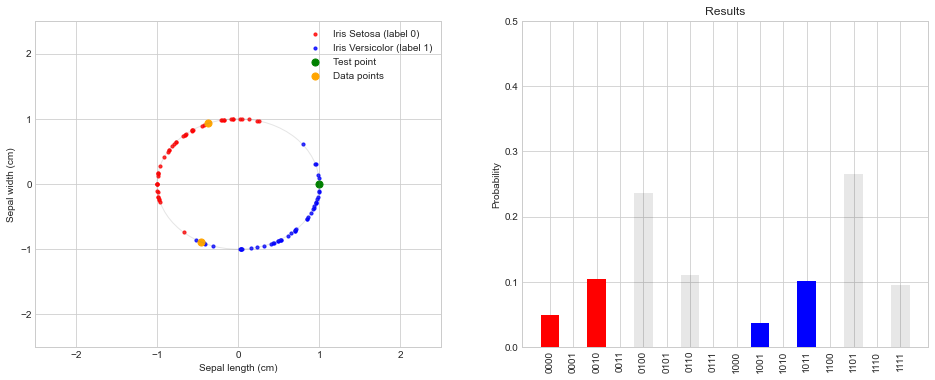

In [3]:
## 2 points distance-based classifier ##

# Set-up a new connection with qi_backend:
def initialize_qi_backend(project_name = "distance_based_classifier"):
    compiler_engines = restrictedgateset.get_engine_list(one_qubit_gates="any",
                                                         two_qubit_gates=(CNOT, CZ, Toffoli))
    compiler_engines.extend([ResourceCounter()])
    qi = QuantumInspireAPI(
        r'https://api.quantum-inspire.com/',
        authentication,
        project_name = project_name  # Set project name to save projects
    ) 
    qi_backend = QIBackend(num_runs=1, quantum_inspire_api=qi)# set num_runs = 1 for true probability distribution
    qi_engine = MainEngine(backend=qi_backend, engine_list=compiler_engines)
    return qi_backend, qi_engine


qi_backend, qi_engine = initialize_qi_backend("distance_based_classifier_2_points")
# Data points:
x_tilde = [0.9999, -0.0011] # Label 1
x0 = [-0.4583, -0.8889]     # Label 1
x1 = [-0.3728, 0.9279]      # Label 0

# Angles data points:
angle_x_tilde = 2 * acos(x_tilde[0]) * sign(x_tilde[1]) # Label 1
angle_x0 = 2 * acos(x0[0]) * sign(x0[1])                # Label 1
angle_x1 = 2 * acos(x1[0]) * sign(x1[1])                # Label 0

# Quantum circuit:
qubits = qi_engine.allocate_qureg(4)

# part_a
for qubit in qubits[0:2]:
    H | qubit

# part_b
C(Ry(angle_x_tilde), 1) | (qubits[1], qubits[2])
X | qubits[1]

# part_c
C(Ry(angle_x1), 2) | (qubits[0], qubits[1], qubits[2])
X | qubits[0]

# part_d
C(Ry(angle_x0), 2) | (qubits[0], qubits[1], qubits[2])

# part_e
CNOT | (qubits[0], qubits[3])

# part_f
H | qubits[1]

qi_engine.flush()

# Results:
temp_results = qi_backend.get_probabilities(qubits)
print(temp_results)  # Print the results in a dictionary
prob = DataPlotter.plot_data_points(x_tilde,[x0], [x1], temp_results)  # Function to plot the data


The classifier predicts the wrong label 0 for the test point with this combination of data points as:
\begin{equation}
0.04 + 0.1043719 > 0.0366663 + 0.1019124  \rightarrow \text{Assign label 0 to } \tilde{y}
\end{equation}
The left figure gives intuition why the classifier fails to predict the correct label. For this specific combination of data points, the test point is closer to the data point with label 0 than to the data point with label 1. As the prediction is based on only these two data points, it is expected to give this wrong prediction. Note, this problem has nothing to do with the quantum computer used for the calculation. The same results would be obtained with a classical distance-based classifier. 

By adding two more data points, one for each label, we improve the classifier so that it is better able to give the right label as prediction. Add the following two points to the calculation:
\begin{equation}
    \begin{split}
        &\ket{\psi_{x_2}}  = -0.3728 \ket{0} +0.9279\ket{1}, \hspace{2cm}y = 1,\\
        &\ket{\psi_{x_3}}  = -0.4583  \ket{0} - 0.8889\ket{1}, \hspace{2cm}y = 0.
    \end{split}
\end{equation}

Consider the quantum circuit for the four point classifier below.

{'01110': 0.2476628, '00011': 0.2373197, '11111': 0.1306251, '10110': 0.1200422, '10000': 0.0531932, '10100': 0.0531932, '11001': 0.0500852, '11101': 0.0500852, '10010': 0.023571, '11011': 0.019204, '00001': 0.0062575, '00101': 0.0062575, '01000': 0.0011657, '01100': 0.0011657, '00111': 0.000165, '01010': 5.5e-06} 



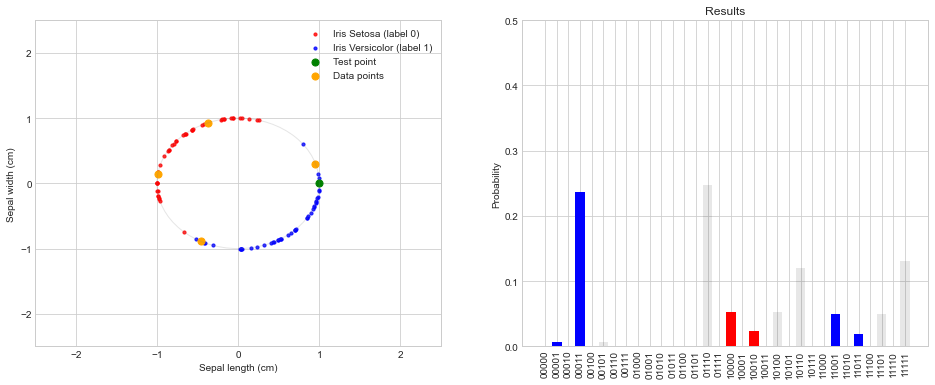

In [4]:
## 4 points distance-based classifier ##

# Add the 2 new data points:
x_tilde = [0.9999, -0.0011] # Label 1
x0 = [-0.4583, -0.8889]    # Label 1
x1 = [-0.3728, 0.9279]     # Label 0
x2 = [-0.9886, 0.1503]     # Label 0
x3 = [0.9530, 0.3028]      # Label 1


def four_point_distance_based_classifier_circuit(x_tilde, x0, x1, x2, x3):
    # Set-up a new connection with qi_backend:
    qi_backend, qi_engine = initialize_qi_backend("distance_based_classifier_4_points")
    
    # Angles data points:
    angle_x_tilde = 2 * acos(x_tilde[0]) * sign(x_tilde[1])
    angle_x0 = 2 * acos(x0[0]) * sign(x0[1])   # Label 1
    angle_x1 = 2 * acos(x1[0]) * sign(x1[1])   # Label 0
    angle_x2 = 2 * acos(x2[0]) * sign(x2[1])   # Label 0
    angle_x3 = 2 * acos(x3[0]) * sign(x3[1])   # Label 1
    
    # Quantum circuit:
    qubits = qi_engine.allocate_qureg(5)

    # part_a
    for qubit in qubits[0:3]:
        H | qubit

    # part_b
    C(Ry(angle_x_tilde), 1) | (qubits[2], qubits[3])
    X | qubits[3]

    # part_c
    for angle in [angle_x0, angle_x1, angle_x2]:
        C(Ry(angle), 3) | (qubits[0], qubits[1], qubits[2], qubits[3]) #C1
        CNOT | (qubits[1], qubits[0]) #C2
        X | qubits[1]
    C(Ry(angle_x3), 3) | (qubits[0], qubits[1], qubits[2], qubits[3]) #C1

    # part_d
    Toffoli | (qubits[0], qubits[1], qubits[4]) #D1
    CNOT | (qubits[1], qubits[0]) #D2
    X | qubits[1]
    Toffoli | (qubits[0], qubits[1], qubits[4]) #D1

    # part_e
    H | qubits[2]

    qi_engine.flush()
    temp_results = qi_backend.get_probabilities(qubits)
    
    # Results:
    temp_results = qi_backend.get_probabilities(qubits)
    return temp_results 


temp_results = four_point_distance_based_classifier_circuit(x_tilde, x0, x1, x2, x3)
print(temp_results, '\n')
prob = DataPlotter.plot_data_points(x_tilde, [x1, x2], [x0, x3], temp_results)  # Function to plot the data

Just as we did in previous notebook, we need to count only those outcomes where the third qubit is equal to a 0. That is, we only consider the 16 outcomes in the set:  
$$\{00000, 01000, 10000, 11000, 00001, 01001, 10001, 11001, 00010, 01010, 10010, 11010, 00011, 01011, 10011, 11011\}$$

The label $\tilde{y}$ is then given by a majority vote:

\begin{equation}
\begin{split}
\tilde{y}_{0} = \# \{00000, 01000, 10000, 11000, 00010, 01010, 10010, 11010\}\\
\tilde{y}_{1} = \#\{00001, 01001, 10001, 11001, 00011, 01011, 10011, 11011\}
\end{split}
\end{equation}


\begin{equation}
\tilde{y} = \left\{
  \begin{array}{lr}
    -1 & : \tilde{y}_{0} > \tilde{y}_{1}\\
    +1 & : \tilde{y}_{1} > \tilde{y}_{0}
  \end{array}
\right.    
\end{equation}


In [5]:
def summarize_results_4_points(prob, display=1):
    def get_label_0_1(n, index_0, index_label):
        # n = number of qubits excluding ancillas
        # index_0 = index of bit that should always be zero to continue
        # index_label = index of bit that should be used to classify in label 0 and label 1
        index_0 = [i for i in range(2**n) if (format(i, '#0{0}b'.format(2+n))[2+index_0] == '0')]
        label0index = [i for i in index_0 if (format(i, '#0{0}b'.format(2+n))[2+index_label] == '0')]
        label1index = [i for i in index_0 if (format(i, '#0{0}b'.format(2+n))[2+index_label] == '1')]
        return label0index, label1index
    label0indx, label1indx = get_label_0_1(5, 2, 4)
    sum_label0 = 0
    sum_label1 = 0
    
    for indx in label0indx:
        sum_label0 += prob[indx]
    for indx in label1indx:
        sum_label1 += prob[indx]


    def y_tilde():
        if sum_label0 > sum_label1:
            return 0, ">"
        elif sum_label0 < sum_label1:
            return 1, "<"
        else:
            return "undefined", "="
    y_tilde_res, sign = y_tilde()
    if display:
        print("The sum of the events with label 0 is: {}".format(sum_label0))
        print("The sum of the events with label 1 is: {}".format(sum_label1))
        print("The label for y_tilde is: {} because sum_label0 {} sum_label1".format(y_tilde_res, sign))
    return y_tilde_res


summarize_results_4_points(prob);

The sum of the events with label 0 is: 0.0779354
The sum of the events with label 1 is: 0.3128664
The label for y_tilde is: 1 because sum_label0 < sum_label1


By adding these two points we see that the classifier now gives the correct label for the test data. To see how well this 4-point distance-based classifier performs we also apply it to randomly selected training and test data. 

The sum of the events with label 0 is: 0.4110741
The sum of the events with label 1 is: 0.0409845
The label for y_tilde is: 0 because sum_label0 > sum_label1


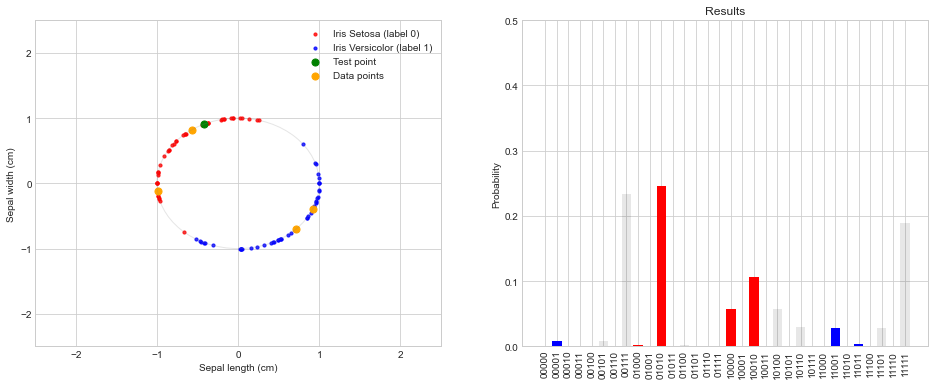

In [6]:
# Get random data
data_label_0, data_label_1, x_tilde, random_label = DataPlotter.grab_random_data(size=4)
x1, x2 = data_label_0
x0, x3 = data_label_1

temp_results = four_point_distance_based_classifier_circuit(x_tilde, x0, x1, x2, x3)
prob = DataPlotter.plot_data_points(x_tilde, data_label_0, data_label_1, temp_results)  # Function to plot the data
summarize_results_4_points(prob);

<a name="conclusion"></a>
# Conclusion and further work #

In general, a distance-based classifier gets better in predicting classes once more data is included. In this notebook we showed how to extend the previous algorithm to 4 data points. We saw an example where the 2-point distance-based classifier fails to predict the right label, while, when extended to four data points, it managed to classify the test point correctly. This is what we expect classically, however, the key takeaway here is that the quantum algorithm itself (step f) did not change. It is independent of the size of dataset and it is from this that we can expect huge speedups.

Extending the classifier to more data points is now analogus. Extending the classifier to $8$ data points will be a nice challenge for the reader to test their understanding, a solution is given below.

In this notebook we used the projectQ backend to generate the quantum algorithm. Note that for controlled gate operations in generall ancillary qubits are required. ProjectQ code does not minimize the amount of ancillary qubits needed in the algorithm, this could be improved.  

The next notebook in this series will look at how to include more than two features for the data. 

[Back to Table of Contents](#contents)

### References ###
* Book: [Schuld and Petruccione, Supervised learning with Quantum computers, 2018](https://www.springer.com/us/book/9783319964232)  
* Article: [Schuld, Fingerhuth and Petruccione, Implementing a distance-based classifier with a quantum interference circuit, 2017](https://arxiv.org/abs/1703.10793)

# Solution for 8 data points


{'100000': 0.1068858, '110000': 0.1034596, '011101': 0.0987508, '101101': 0.0926906, '000000': 0.0816552, '001101': 0.0775523, '010000': 0.071826, '111001': 0.0592897, '111111': 0.0585862, '010010': 0.0501968, '001111': 0.0458293, '000010': 0.0424755, '101111': 0.0323009, '011111': 0.0256349, '110110': 0.0193298, '100110': 0.0127306, '100010': 0.0048103, '111011': 0.0035832, '111101': 0.0035406, '110010': 0.0018623, '010110': 0.0017523, '010100': 0.0012246, '001011': 0.0010171, '001001': 0.000601, '100100': 0.0005729, '000110': 0.0005717, '011011': 0.0004874, '110100': 0.0003479, '000100': 0.0002974, '011001': 0.0001265, '101011': 6.1e-06, '101001': 2.1e-06}
Sum Iris Setosa (red, label 0):  0.46317149999999996
Sum Iris Versicolor (blue, label 1):  0.06511310000000001


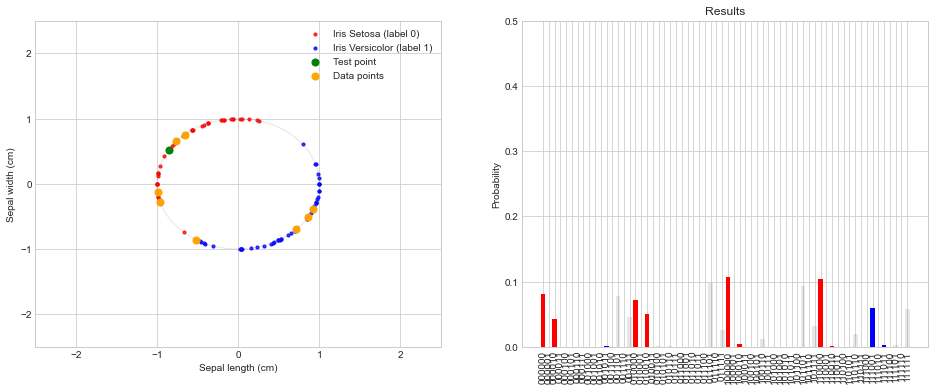

In [7]:
## 8 points distance-based classifier ##
### Note: Far from qubit optimal solution

# Get data:
data_label_0, data_label_1, x_tilde, random_label = DataPlotter.grab_random_data(size=8)


def eight_point_distance_based_classifier_circuit(x_tilde, data_label_0, data_label_1):
    # Set-up a new connection with qi_backend:
    qi_backend, qi_engine = initialize_qi_backend("distance_based_classifier_8_points")
    
    # Angles data points:
    angle_label0 = []
    angle_label1 = []
    for data_point in data_label_0:
        angle_label0.append(2 * acos(data_point[0]) * sign(data_point[1]))
    for data_point in data_label_1:
        angle_label1.append(2 * acos(data_point[0]) * sign(data_point[1]))
    angle_x_tilde = 2 * acos(x_tilde[0]) * sign(x_tilde[1])
    
    # Quantum circuit:
    qubits = qi_engine.allocate_qureg(9)  # 6 qubits + 3 ancillary qubits for CCCCRy gates
    
    # part_a
    for qubit in qubits[0:4]:
        H | qubit

    # part_b
    C(Ry(angle_x_tilde), 1) | (qubits[3], qubits[4])
    X | qubits[3]

    # part_c
    for angle in angle_label1:
        # Build CCCCRy gate from 3 ancillary, Toffoli, and a CRy gate.
        Toffoli | (qubits[0], qubits[1], qubits[6])
        Toffoli | (qubits[2], qubits[6], qubits[7]) 
        Toffoli | (qubits[3], qubits[7], qubits[8]) 
        C(Ry(angle), 1) | (qubits[8], qubits[4])
        Toffoli | (qubits[3], qubits[7], qubits[8]) 
        # Set y_m label conditioned on first three qubits being 1, (don't include 4th qubit)
        CNOT | (qubits[7], qubits[5])
        Toffoli | (qubits[2], qubits[6], qubits[7]) 
        Toffoli | (qubits[0], qubits[1], qubits[6])
        
        Toffoli | (qubits[0], qubits[1], qubits[2])
        CNOT | (qubits[0], qubits[1])
        X | qubits[0]
          
    for angle in angle_label0:
        # Build CCCCRy gate from 3 ancillary, Toffoli, and a CRy gate.
        Toffoli | (qubits[0], qubits[1], qubits[6])
        Toffoli | (qubits[2], qubits[6], qubits[7]) 
        Toffoli | (qubits[3], qubits[7], qubits[8]) 
        C(Ry(angle), 1) | (qubits[8], qubits[4])
        Toffoli | (qubits[3], qubits[7], qubits[8]) 
        Toffoli | (qubits[2], qubits[6], qubits[7]) 
        Toffoli | (qubits[0], qubits[1], qubits[6])
        
        Toffoli | (qubits[0], qubits[1], qubits[2])
        CNOT | (qubits[0], qubits[1])
        X | qubits[0] 

    # part_d
    H | qubits[3]

    qi_engine.flush()
    temp_results = qi_backend.get_probabilities(qubits)
    
    # Results:
    temp_results = qi_backend.get_probabilities(qubits)
    return temp_results 


temp_results = eight_point_distance_based_classifier_circuit(x_tilde, data_label_0, data_label_1)


def strip_ancillary_qubits(results):
    histogram_results = {}
    for k, v in results.items():
        histogram_results[k[:-3]] = v  # Strip ancillary qubits
    return histogram_results


histogram_results = strip_ancillary_qubits(temp_results)
print(histogram_results)


def summarize_results_8_points(histogram_results):
    sum_label0 = 0
    sum_label1 = 0
    for key, value in histogram_results.items():
        if key[3] == "0":
            if key[-1] == "0":
                sum_label0 += value
            else:
                sum_label1 += value
    print("Sum Iris Setosa (red, label 0): ", sum_label0)
    print("Sum Iris Versicolor (blue, label 1): ", sum_label1)

    
summarize_results_8_points(histogram_results)
# Function to plot the data
prob = DataPlotter.plot_data_points(x_tilde, data_label_0, data_label_1, histogram_results)